In [ ]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Disable warnings
warnings.filterwarnings("ignore")

In [ ]:
# Data Collection
# Assuming the dataset is organized in directories, each containing images of a specific class
path = r"/kaggle/input/adni-extracted-axial/Axial"
data = tf.keras.utils.image_dataset_from_directory(directory=path, image_size=(128, 128), batch_size=10000)

# Mapping class indices to class names
class_names = data.class_names
label_map = {m: n for m, n in zip(np.arange(len(class_names)), class_names)}

In [ ]:
# Loading images and labels
X, y = None, None
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")

# Convert images to grayscale
X_gray = np.zeros(shape=(*X.shape[:-1], 1))
for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()

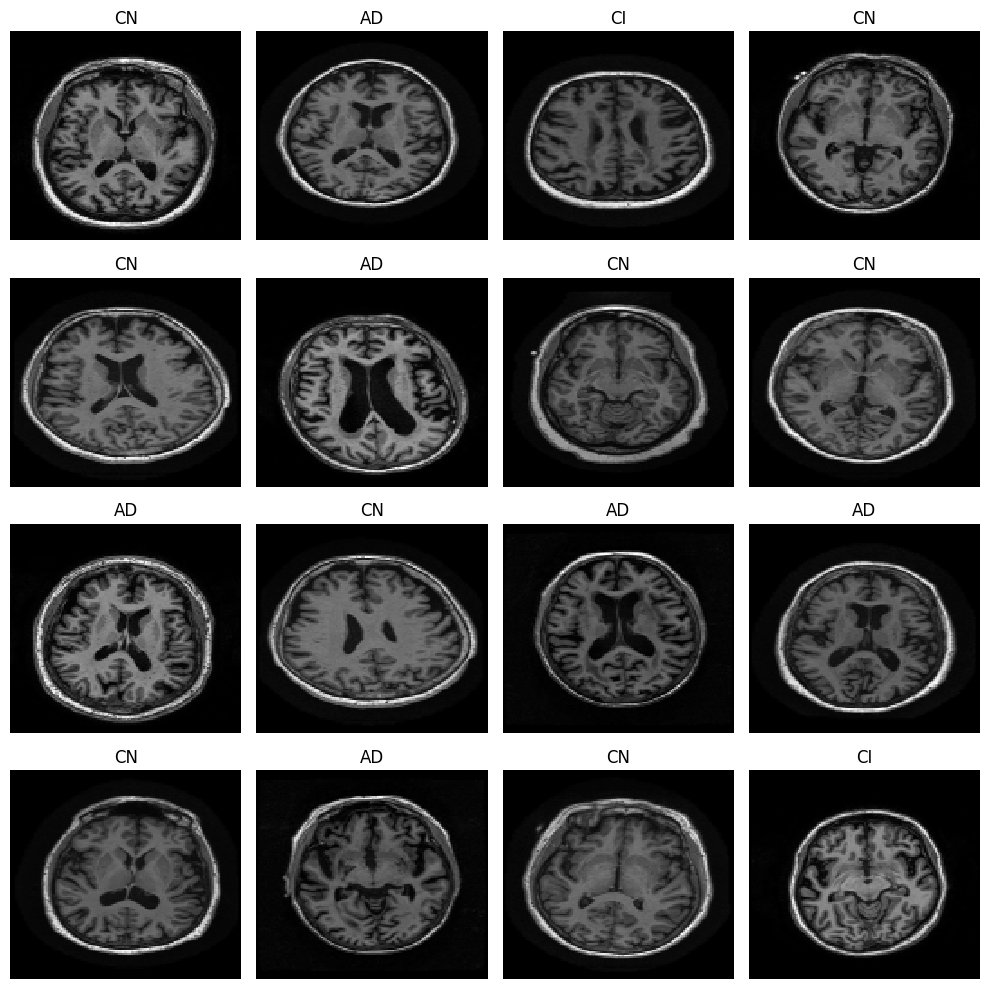

In [ ]:
# Data Visualization
def plot_images(images, labels, label_map, num_images=16):
    # Function to plot sample images with labels
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        img = images[i]
        plt.subplot(4, 4, i + 1)
        plt.title(label_map[labels[i]])
        sns.heatmap(img[:, :, 0], cmap="gray", cbar=False, xticklabels=False, yticklabels=False)
        plt.tight_layout()
    plt.show()

plot_images(X, y, label_map)

In [ ]:
# Data Augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
])

In [ ]:
# Augmenting the dataset
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

# Define label_counts
label_counts = pd.Series(y).value_counts()

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1

X_new, y_new = np.array(X_new), np.array(y_new)
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

# Data Preprocessing and Preparation
X = X / 255.0

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Model Building and Training
model = models.Sequential([
    layers.Conv2D(filters=200, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation="relu"),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Conv2D(filters=100, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation="relu"),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Flatten(),
    layers.Dense(units=100, activation="relu"),
    layers.Dense(units=50, activation="relu"),
    layers.Dense(units=3, activation="softmax")
])

# Summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 126, 126, 200)     2000      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 42, 42, 200)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 40, 40, 100)       180100    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 13, 13, 100)       0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 16900)             0         
                                                                 
 dense_19 (Dense)            (None, 100)             

In [ ]:
# Model compilation
model.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

In [ ]:
# Model callbacks
checkpoint_cb = callbacks.ModelCheckpoint("clf_model.h5", save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Model training
history = model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint_cb, early_stopping_cb], validation_split=0.15)

Epoch 1/100
192/192 [==============================] - 6s 22ms/step - loss: 0.9759 - accuracy: 0.5006 - val_loss: 0.7906 - val_accuracy: 0.6309
Epoch 2/100
192/192 [==============================] - 4s 21ms/step - loss: 0.7217 - accuracy: 0.7874 - val_loss: 0.4041 - val_accuracy: 0.8363
Epoch 3/100
192/192 [==============================] - 4s 21ms/step - loss: 0.4841 - accuracy: 0.8741 - val_loss: 0.4012 - val_accuracy: 0.8677
Epoch 4/100
192/192 [==============================] - 4s 21ms/step - loss: 0.4601 - accuracy: 0.9203 - val_loss: 0.2523 - val_accuracy: 0.9251
Epoch 5/100
192/192 [==============================] - 4s 20ms/step - loss: 0.2704 - accuracy: 0.9580 - val_loss: 0.1721 - val_accuracy: 0.9473
Epoch 6/100
192/192 [==============================] - 4s 21ms/step - loss: 0.1890 - accuracy: 0.9621 - val_loss: 0.1663 - val_accuracy: 0.9463
Epoch 7/100
192/192 [==============================] - 4s 20ms/step - loss: 0.1930 - accuracy: 0.9724 - val_loss: 0.1490 - val_accuracy:

In [ ]:
# Model Evaluation on Train Set
loss, acc = model.evaluate(X_train, y_train)

226/226 [==============================] - 1s 6ms/step - loss: 0.0388 - accuracy: 0.9911


226/226 [==============================] - 1s 5ms/step


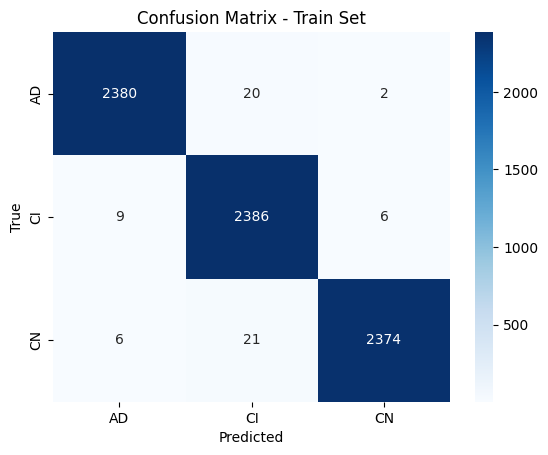

In [ ]:
# Confusion Matrix
y_train_pred = model.predict(X_train)
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
cm = tf.math.confusion_matrix(labels=y_train, predictions=y_train_pred_labels)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Train Set")
plt.show()

In [ ]:
# Model Validation on Test Set
loss, acc = model.evaluate(X_test, y_test)

57/57 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.9734


57/57 [==============================] - 0s 5ms/step


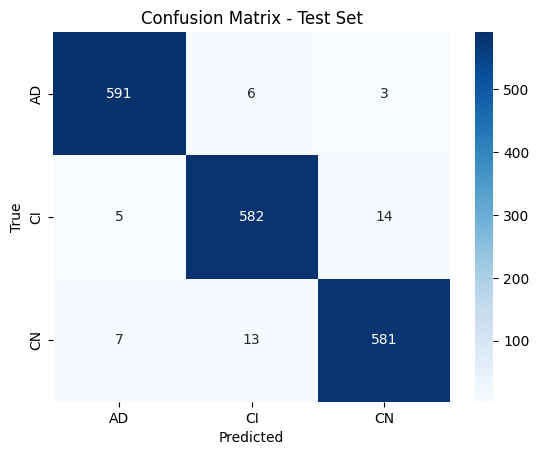

In [ ]:
# Confusion Matrix
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_test_pred_labels)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:
# Save the Model
model.save("clf_model_final.h5")